In [1]:
import numpy as np
import pandas as pd

from ast import literal_eval

import gensim.utils as g_utils

import re
import string

import emoji

from nltk.corpus import stopwords

/Users/nmm/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load the data

In [15]:
LIST_DICTS = ["hashtags"
              , "urls"
              , "user_mentions"
              , "symbols"
              , "media"
              , "bounding_box"
             ]

def try_literal_eval(s):
    """ load python object as they are intended to be """
    try:
        return literal_eval(s)
    except ValueError:
        return s
    
def load_data(data_path):
    df = pd.read_csv(data_path).drop(["Unnamed: 0"], axis=1)
    for col in LIST_DICTS:
        df[col] = df[col].apply(try_literal_eval)
        
    return df

def simplify_fields(df):
    df["hashtags"] = [[ht["text"] for ht in hashtags] for hashtags in df.hashtags]
    df["nb_hashtags"] = [len(hashtags) for hashtags in df.hashtags]
    df["urls"] = [len(urls) for urls in df.urls]
    
    return df

In [3]:
df = simplify_fields(load_data("anon_france_15d.csv"))
df.shape

(458919, 17)

In [4]:
df.sample()

,created_at,id_str,text,hashtags,urls,user_mentions,symbols,media,lang,coordinates,place_id,place_type,place_name,place_country,bounding_box,user_id,nb_hashtags
271644,2021-04-11 20:16:29+00:00,1.381340e+18,Putain elle est d’une douceuuuur 😍,[],0,0,[],[],fr,NaN,4d4fdfb131cd110f,city,Saint-Denis,France,"[[[2.333193, 48.901472], [2.333193, 48.952035]...",103381,0


In [5]:
df_fr = df[df.lang=="fr"].copy()
df_fr.shape

(330415, 17)

## NLP preprocessing

In [6]:
mask_ht = np.array([len(ht)>0 for ht in df_fr.hashtags])
mask_url = np.array([url>0 for url in df_fr.urls])
mask_mention = np.array([mention>0 for mention in df_fr.user_mentions])

mask_all = [(h and u and m) for h,u,m in zip(mask_ht, mask_url, mask_mention)]

#df_fr[mask_all]

In [7]:
df_fr.loc[106].text

'Ce bleu ! 🤩 💙\r\n#ILoveNice #ExploreNiceCotedAzur #CotedAzurFrance \r\n@44813 @72232 @68710 @VisitCotedazur https://t.co/afG3C5dIEc'

### Remove urls

In [8]:
%time df_fr["text"] = df_fr["text"].apply(lambda tweet: re.sub(r'http\S+', '', tweet))

CPU times: user 276 ms, sys: 4.36 ms, total: 280 ms
Wall time: 279 ms


In [9]:
df_fr.loc[106].text

'Ce bleu ! 🤩 💙\r\n#ILoveNice #ExploreNiceCotedAzur #CotedAzurFrance \r\n@44813 @72232 @68710 @VisitCotedazur '

### Remove mentions

In [10]:
%time df_fr["text"] = df_fr["text"].apply(lambda tweet: re.sub(r'@\S+', '', tweet))

CPU times: user 338 ms, sys: 4.48 ms, total: 343 ms
Wall time: 342 ms


In [11]:
df_fr.loc[106].text

'Ce bleu ! 🤩 💙\r\n#ILoveNice #ExploreNiceCotedAzur #CotedAzurFrance \r\n    '

### Remove hashtags

In [12]:
%time df_fr["text"] = df_fr["text"].apply(lambda tweet: re.sub(r'#\S+', '', tweet))

CPU times: user 284 ms, sys: 2.05 ms, total: 286 ms
Wall time: 285 ms


In [13]:
df_fr.loc[106].text

'Ce bleu ! 🤩 💙\r\n   \r\n    '

### Remove punctuation

In [14]:
%time df_fr["text"] = df_fr["text"].apply(lambda tweet: tweet.translate(str.maketrans('', '', string.punctuation)))

CPU times: user 1.79 s, sys: 13 ms, total: 1.8 s
Wall time: 1.8 s


In [15]:
df_fr.loc[106].text

'Ce bleu  🤩 💙\r\n   \r\n    '

### Remove smileys

In [16]:
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

In [17]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [17]:
%time df_fr["text"] = df_fr["text"].apply(give_emoji_free_text)

CPU times: user 1min 49s, sys: 295 ms, total: 1min 49s
Wall time: 1min 49s


In [18]:
df_fr.loc[106].text

'Ce bleu   \r\n   \r\n    '

### Tokenize

In [19]:
%time df_fr["tokens"] = df_fr["text"].apply(lambda tweet: list(g_utils.tokenize(tweet, deacc=False, lowercase=True)))

CPU times: user 3.42 s, sys: 51 ms, total: 3.47 s
Wall time: 3.47 s


In [20]:
df_fr.loc[106].tokens

['ce', 'bleu']

### Remove stopwords

In [21]:
STOP_WORDS = stopwords.words("french")

In [22]:
def clean_tokens(tokens, stopwords=STOP_WORDS):
    cleaned_tokens = [token for token in tokens
                      if not (token in stopwords
                              or token.isnumeric()
                              or len(token)<3
                             )
                     ]
    return cleaned_tokens

In [23]:
%time df_fr["tokens_cleaned"] = df_fr["tokens"].apply(clean_tokens)

CPU times: user 5.5 s, sys: 23.8 ms, total: 5.52 s
Wall time: 5.52 s


In [26]:
df_fr.loc[106].tokens_cleaned

['bleu']

<AxesSubplot:>

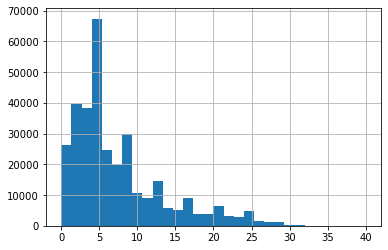

In [24]:
df_fr["tokens_cleaned"].apply(len).hist(bins=30)

## POS tagging

In [23]:
# done with spacy-lefff in an external notebook
df_lemma = pd.read_csv("cleaned_lemmatized_tweets.csv").set_index("Unnamed: 0")#, axis=1)
df_lemma["text_clean"] = df_lemma["text_clean"].apply(literal_eval)
df_lemma.shape

(330415, 1)

In [24]:
df_lemma.sample(2)

,text_clean
Unnamed: 0,
102063,"[(ComeBack2, NOUN, comeback2), (le, DET, le), ..."
49062,"[(Bonjour, PROPN, bonjour)]"


In [26]:
df_fr.sample(2)

,created_at,id_str,text,hashtags,urls,user_mentions,symbols,media,lang,coordinates,...,place_type,place_name,place_country,bounding_box,user_id,nb_hashtags,text_clean,tokens,tokens_cleand,len_tc
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
233674,2021-04-24 16:00:52+00:00,1.385987e+18,@114300 Bientot ouais ils ma ruiner celui la 😅😅,[],0,1,[],[],fr,NaN,...,city,Pontault-Combault,France,"[[[2.585433, 48.760998], [2.585433, 48.815954]...",38690,0,Bientot ouais ils ma ruiner celui la,"['bientot', 'ouais', 'ils', 'ma', 'ruiner', 'c...","['bientot', 'ouais', 'ruiner', 'celui']",4
69038,2021-04-18 16:01:23+00:00,1.383813e+18,Un beau dimanche de collage pour lancer la cam...,['Creteil'],1,2,[],[],fr,NaN,...,admin,Val-de-Marne,France,"[[[2.308671, 48.687562], [2.308671, 48.861575]...",8307,1,Un beau dimanche de collage pour lancer la cam...,"['un', 'beau', 'dimanche', 'de', 'collage', 'p...","['beau', 'dimanche', 'collage', 'lancer', 'cam...",6


In [34]:
df_fr.sort_index(inplace=True)
df_lemma.sort_index(inplace=True)

In [37]:
np.sum([0 if (f_id==l_id) else 1 for (f_id, l_id) in zip(df_fr.index.values, df_lemma.index.values)])

0

In [40]:
df_lemma.rename({"text_clean":"w_pos_lemma"}, axis=1, inplace=True)

In [41]:
df_fr["w_pos_lemma"] = df_lemma["w_pos_lemma"]

In [49]:
df_fr.sample(3)#[["text", "text_clean", "w_pos_lemma"]].sample(5)

,created_at,id_str,text,hashtags,urls,user_mentions,symbols,media,lang,coordinates,...,place_name,place_country,bounding_box,user_id,nb_hashtags,text_clean,tokens,tokens_cleand,len_tc,w_pos_lemma
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
28816,2021-04-13 16:58:15+00:00,1.382015e+18,Parce que @50055 est au ❤️ de l'actualité et p...,[],1,1,[],[],fr,NaN,...,Saint-Jean-de-Védas,France,"[[[3.80461, 43.550941], [3.80461, 43.595643], ...",120422,0,Parce que est au ❤️ de lactualité et proche d...,"['parce', 'que', 'est', 'au', 'de', 'lactualit...","['parce', 'lactualite', 'proche', 'acteurs', '...",17,"[(Parce, SCONJ, parce), (que, SCONJ, que), ( ,..."
280301,2021-04-20 15:31:15+00:00,1.384530e+18,BRAVO @56576 pour cette première présentation ...,['FigaroLive'],0,2,[],['photo'],fr,NaN,...,Paris,France,"[[[2.224101, 48.815521], [2.224101, 48.902146]...",21657,1,BRAVO pour cette première présentation dans \...,"['bravo', 'pour', 'cette', 'premiere', 'presen...","['bravo', 'cette', 'premiere', 'presentation']",4,"[(BRAVO, PROPN, bravo), ( , SPACE, ), (pour, ..."
150703,2021-04-20 22:09:59+00:00,1.384630e+18,@71800 Rip Roach\r\n\r\n( Bob l'éponge qui reg...,[],0,1,[],[],fr,NaN,...,Villiers-le-Bel,France,"[[[2.378877, 48.991868], [2.378877, 49.024132]...",83350,0,Rip Roach\r\n\r\n Bob léponge qui regarde un ...,"['rip', 'roach', 'bob', 'leponge', 'qui', 'reg...","['rip', 'roach', 'bob', 'leponge', 'regarde', ...",8,"[( , SPACE, ), (Rip, NOUN, rip), (Roach, PROP..."


In [48]:
#df_fr.to_csv("tweets_nlp.csv")

In [16]:
%%time
df_fr = load_data("tweets_nlp.csv")
df_fr.sample()

CPU times: user 16.5 s, sys: 262 ms, total: 16.8 s
Wall time: 16.8 s


,created_at,id_str,text,hashtags,urls,user_mentions,symbols,media,lang,coordinates,...,place_name,place_country,bounding_box,user_id,nb_hashtags,text_clean,tokens,tokens_cleand,len_tc,w_pos_lemma
310953,2021-04-12 13:01:47+00:00,1.381593e+18,@102900 Ça fait deux la !,[],0,1,[],[],fr,NaN,...,Ajaccio,France,"[[[8.591837, 41.893916], [8.591837, 41.97156],...",50743,0,Ça fait deux la,"['ca', 'fait', 'deux', 'la']","['fait', 'deux']",2,"[(' ', 'SPACE', ' '), ('Ça', 'PRON', 'ça'), ('..."


## Geo enrichment

In [24]:
import geopandas as gpd

In [26]:
geo_regions = "./geodata/regions.geojson"
gdf_regions = gpd.read_file(geo_regions)
geo_departements = "./geodata/departements.geojson"
gdf_departements = gpd.read_file(geo_departements)

In [27]:
def get_bb_center(bb):
    center_lon,center_lat = ( np.average([bb[0][0][0], bb[0][2][0]]),np.average([bb[0][0][1], bb[0][2][1]]))
    return (center_lon,center_lat)

In [28]:
from shapely.geometry import Point, Polygon, MultiPolygon

def get_geo_code(gdf, point):
    pt = Point(point)
    for i, polygon in enumerate(gdf.geometry):
        if pt.within(polygon):
            return gdf.at[i,'code']
    return False
        

In [29]:
df_fr["bb_center"] = [get_bb_center(bounding_box) for bounding_box in df_fr.bounding_box]

In [30]:
df_fr["reg_code"] = [get_geo_code(gdf_regions, point) for point in df_fr.bb_center]
df_fr["dep_code"] = [get_geo_code(gdf_departements, point) for point in df_fr.bb_center]

In [31]:
df_fr_geo = df_fr[df_fr.reg_code != False].reset_index(drop=True)
df_fr_geo = df_fr_geo[df_fr_geo.dep_code != False].reset_index(drop=True)
df_fr_geo

,created_at,id_str,text,hashtags,urls,user_mentions,symbols,media,lang,coordinates,...,user_id,nb_hashtags,text_clean,tokens,tokens_cleand,len_tc,w_pos_lemma,bb_center,reg_code,dep_code
0,2021-04-23 14:16:55+00:00,1.385599e+18,Il va sans dire que je m’inclus dans le niveau...,[],0,0,[],[],fr,NaN,...,139315,0,Il va sans dire que je m’inclus dans le niveau...,"['il', 'va', 'sans', 'dire', 'que', 'je', 'm',...","['sans', 'dire', 'inclus', 'niveau', 'general']",5,"[('Il', 'PRON', 'il'), ('va', 'VERB', 'aller')...","(2.1641665, 48.836563)",11,92
1,2021-04-23 14:17:02+00:00,1.385599e+18,@108135 Ajd je te dirai mumblecore. Demain je ...,[],0,1,[],[],fr,NaN,...,6971,0,Ajd je te dirai mumblecore Demain je te dirai...,"['ajd', 'je', 'te', 'dirai', 'mumblecore', 'de...","['ajd', 'dirai', 'mumblecore', 'demain', 'dira...",10,"[(' ', 'SPACE', ' '), ('Ajd', 'PROPN', 'Ajd'),...","(2.405564, 48.8840255)",11,93
2,2021-04-23 14:17:02+00:00,1.385599e+18,@14511 @103195 Est ce que ce guignol sait que ...,[],1,2,[],[],fr,NaN,...,47994,0,Est ce que ce guignol sait que la confiance ...,"['est', 'ce', 'que', 'ce', 'guignol', 'sait', ...","['guignol', 'sait', 'confiance', 'envers', 'me...",8,"[(' ', 'SPACE', ' '), ('Est', 'NOUN', 'est')...","(-1.7629005, 43.3635405)",75,64
3,2021-04-23 14:17:10+00:00,1.385599e+18,"MU, Liverpool et l’atletico parmis ceux là ? M...",[],0,0,[],[],fr,NaN,...,91185,0,MU Liverpool et l’atletico parmis ceux là Mdr...,"['mu', 'liverpool', 'et', 'l', 'atletico', 'pa...","['liverpool', 'atletico', 'parmis', 'ceux', 'm...",7,"[('MU', 'NOUN', 'mu'), ('Liverpool', 'PROPN', ...","(7.7093834999999995, 48.546882)",44,67
4,2021-04-23 14:17:14+00:00,1.385599e+18,Des champs de désolation,[],0,0,[],[],fr,NaN,...,49702,0,Des champs de désolation,"['des', 'champs', 'de', 'desolation']","['champs', 'desolation']",2,"[('Des', 'DET', 'un'), ('champs', 'NOUN', 'cha...","(3.8742675, 43.610396)",76,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328507,2021-04-23 02:13:09+00:00,1.385416e+18,@101021 J’espère que l’on n’aura pas droit à l...,[],0,1,[],[],fr,NaN,...,35914,0,J’espère que l’on n’aura pas droit à la part ...,"['j', 'espere', 'que', 'l', 'on', 'n', 'aura',...","['espere', 'droit', 'part', 'neg', 'parce', 'v...",8,"[(' ', 'SPACE', ' '), ('J’', 'ADJ', 'j’'), ('e...","(2.4492789999999998, 48.7390625)",11,94
328508,2021-04-23 02:13:24+00:00,1.385416e+18,Comment ne pas voir que @10756 est pervers,[],0,1,[],[],fr,NaN,...,38965,0,Comment ne pas voir que est pervers,"['comment', 'ne', 'pas', 'voir', 'que', 'est',...","['comment', 'voir', 'pervers']",3,"[('Comment', 'ADV', 'comment'), ('ne', 'ADV', ...","(2.347003, 48.8588335)",11,75
328509,2021-04-23 02:13:37+00:00,1.385417e+18,@45942 C’est toi aussi tu veux pas me dire 🥺,[],0,1,[],[],fr,NaN,...,35700,0,C’est toi aussi tu veux pas me dire 🥺,"['c', 'est', 'toi', 'aussi', 'tu', 'veux', 'pa...","['aussi', 'veux', 'dire']",3,"[(' ', 'SPACE', ' '), ('C’', 'PROPN', 'C’'), (...","(2.2478525, 48.950032)",11,95
328510,2021-04-23 02:13:47+00:00,1.385417e+18,j'arrive pas a dormir j'ai trop d'images en tête,[],0,0,[],[],fr,NaN,...,121511,0,jarrive pas a dormir jai trop dimages en tête,"['jarrive', 'pas', 'a', 'dormir', 'jai', 'trop...","['jarrive', 'dormir', 'jai', 'trop', 'dimages'...",6,"[('jarrive', 'VERB', 'jarrive'), ('pas', 'ADV'...","(2.08812, 47.8520885)",24,45


In [32]:
#df_fr_geo.to_csv("nlp_geo_tweets.csv")